# Contrôle de TP Apprentissage Automatique 1

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquement de feu, horloge, chant de coq, etc...).

Les fichiers audio sont convertis en spectrogrammes, une représentation temps/fréquence du signal qui peut être vue comme une image.


### Imports



In [21]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [22]:
!pip -q install librosa
import librosa
import librosa.display

### Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [23]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2024-05-02 14:28:20--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M   593KB/s    in 79s     

2024-05-02 14:29:39 (1.56 MB/s) - ‘dataset.zip’ saved [128685900/128685900]

replace data/test/chainsaw/1-64398-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [24]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [25]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))

                    # add associated label
                    labels.append(idx)

    # mélange les données
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [26]:
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 10.1 s, sys: 7.55 s, total: 17.7 s
Wall time: 17.6 s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [27]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [28]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[13] = 0 -> chainsaw
• y_train[50] = 1 -> clock_tick
• y_train[132] = 4 -> dog
• y_train[26] = 0 -> chainsaw
• y_train[74] = 2 -> crackling_fire
• y_train[245] = 7 -> rooster
• y_train[98] = 3 -> crying_baby
• y_train[187] = 5 -> helicopter
• y_train[57] = 1 -> clock_tick
• y_train[197] = 6 -> rain


**Affichage de quelques spectrogrammes**


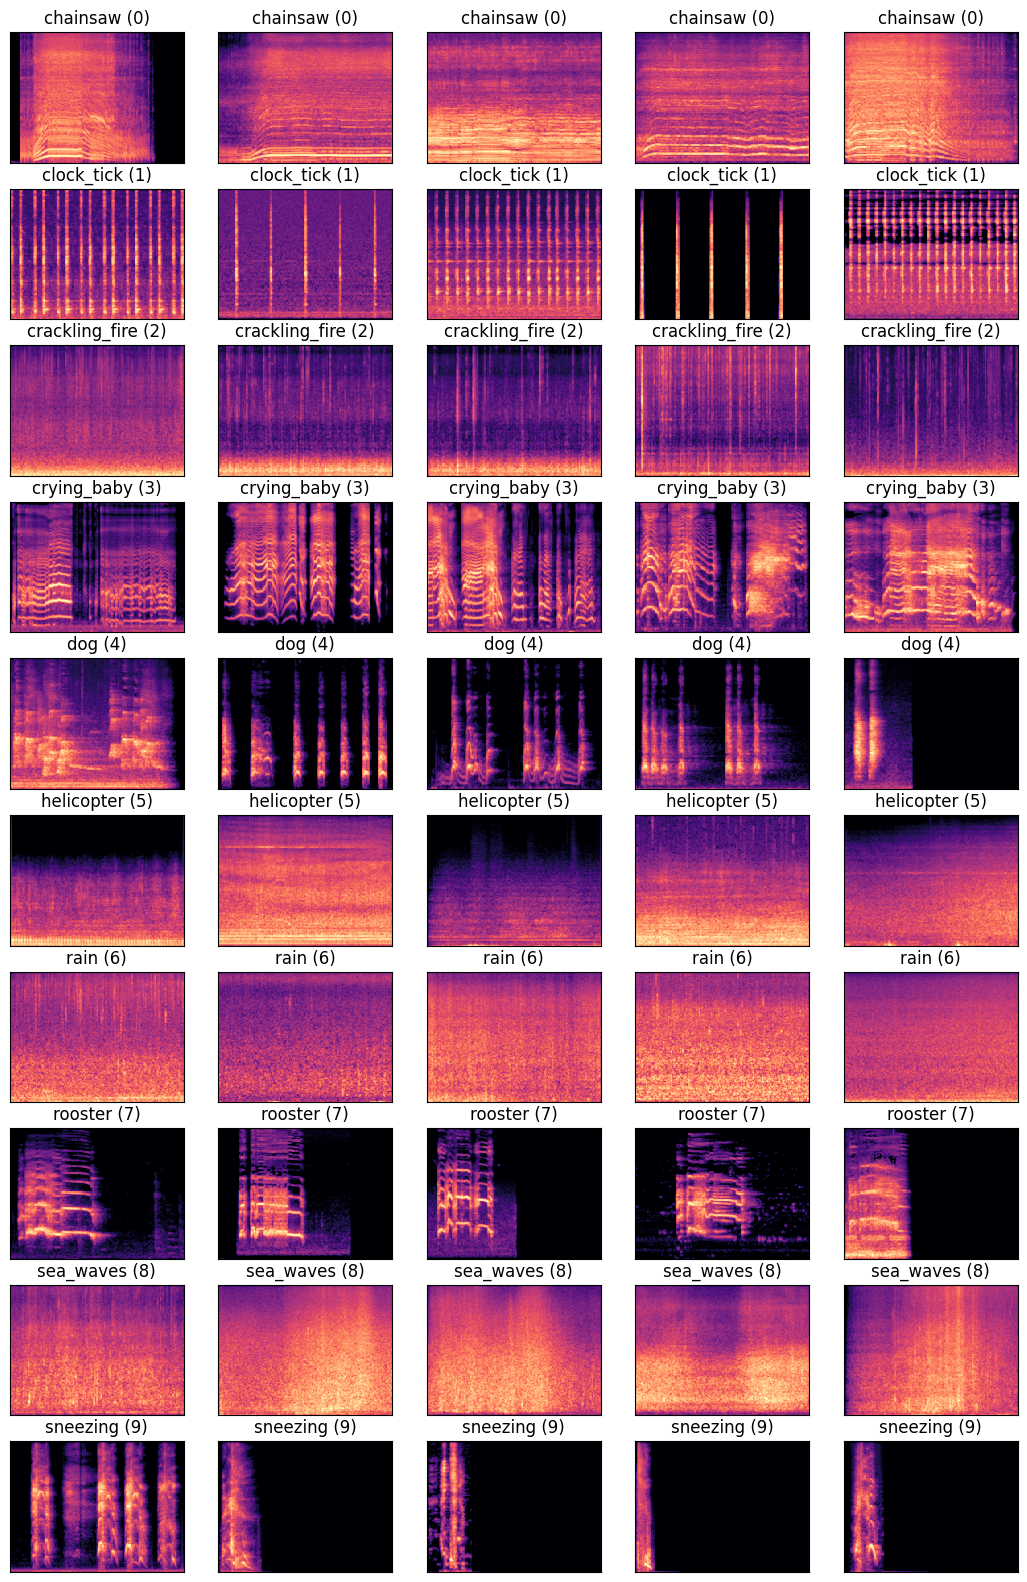

In [29]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32

plt.show()

# Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [30]:
nb_classes = 10

# numpy vers tensors
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)

# numpy vers tensors
X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [31]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [32]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie.

In [13]:
# Perceptron multi-couche
class MLP(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1, 128*216) # flatten le spectro
        out1 = F.relu(self.layer1(flattened))
        out2 = self.layer2(out1)
        return out2


Compléter la fonction d'apprentissage

In [14]:
def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9,
          num_epochs=10):

    # la loss
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # if imgs.size()[0] < batch_size:
            #     continue
            # print(imgs.size())

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out,labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # training accuracy
              val_acc.append(get_accuracy(model, train=False))  # test accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [15]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [16]:
model = MLP(50)
print(model)

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)


Une façon d'évaluer la "complexité" ou la "capacité" d'un réseau est de regarder le nombre de paramètres :

In [17]:
def print_num_parameters(model):
    print("Nombre de paramètres :",
          sum(p.numel() for p in model.parameters()))

print_num_parameters(model)

Nombre de paramètres : 1382960


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


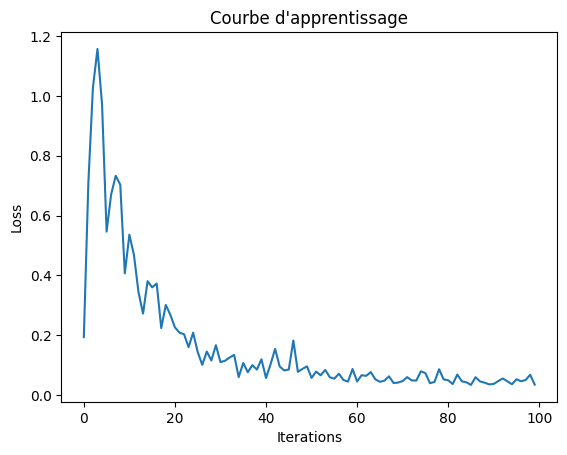

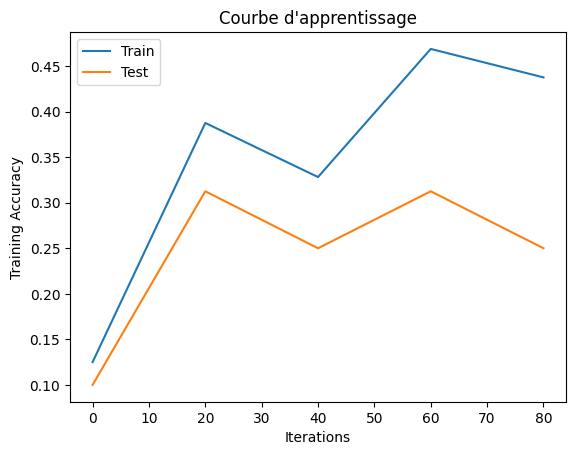

Précision finale Train : 0.4375
Précision finale Test : 0.25


In [ ]:
train(model, batch_size=32, optimizer="adam", learning_rate=0.0001, num_epochs=10)

In [18]:
# Perceptron multi-couche avec changement de nb des couches cachees
class MLP2(nn.Module):
    def __init__(self, num_hidden=70):
        super(MLP2, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1, 128*216) # flatten le spectro
        out1 = F.relu(self.layer1(flattened))
        out2 = self.layer2(out1)
        return out2

In [ ]:
model2 = MLP2()
print(model2)

MLP2(
  (layer1): Linear(in_features=27648, out_features=70, bias=True)
  (layer2): Linear(in_features=70, out_features=10, bias=True)
)


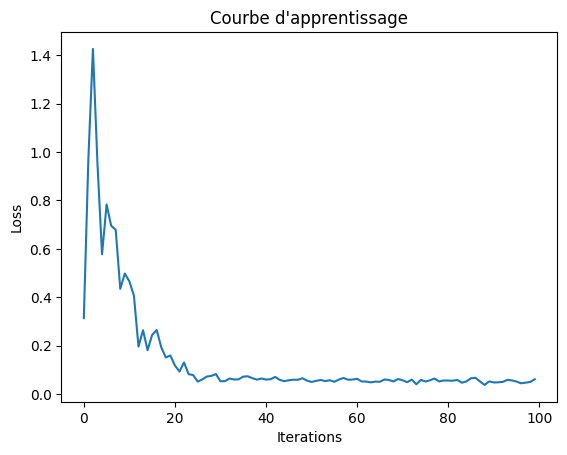

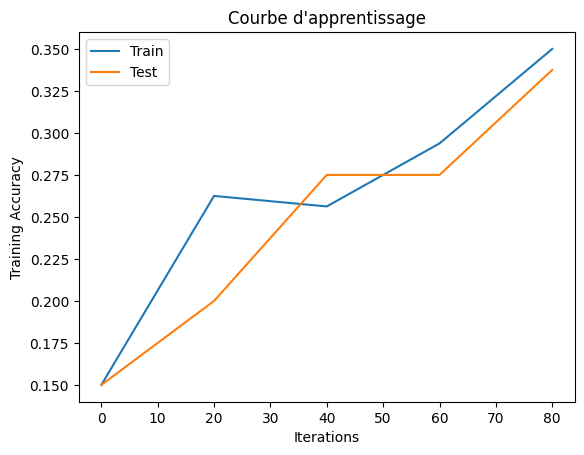

Précision finale Train : 0.35
Précision finale Test : 0.3375


In [ ]:
train(model2, batch_size=32, optimizer="adam", learning_rate=0.0001, num_epochs=10)

In [19]:
#ajout d'une normalisation des activations et modiffication du nombre de couches cachees
class MLP4(nn.Module):
    def __init__(self, num_hidden=70):
        super(MLP4, self).__init__()
        self.layer1 = nn.Linear(128*216, num_hidden)
        self.layer2 = nn.Linear(num_hidden, 10)
        self.batchnorm = nn.BatchNorm1d(num_hidden)

    def forward(self, spectro):
        flattened = spectro.view(-1, 128*216) # flatten le spectro
        out1 = F.relu(self.batchnorm(self.layer1(flattened)))
        out2 = self.layer2(out1)
        return out2

MLP4(
  (layer1): Linear(in_features=27648, out_features=70, bias=True)
  (layer2): Linear(in_features=70, out_features=10, bias=True)
  (batchnorm): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


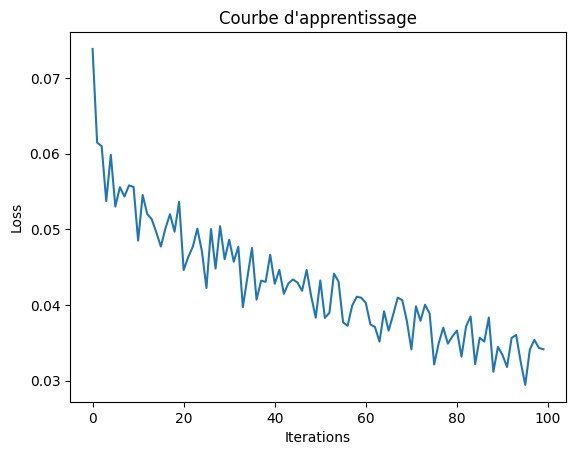

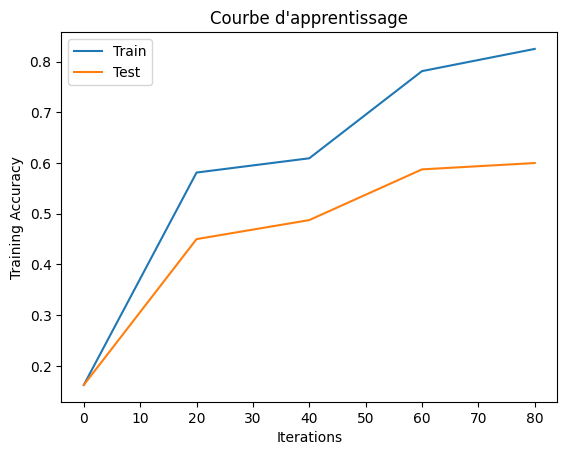

Précision finale Train : 0.825
Précision finale Test : 0.6


In [20]:
model4 = MLP4()
print(model4)

train(model4, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN.

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement.

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes.

Une ReLU sera appliquée après chaque couche de convolution et après fc1.

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                               out_channels=8,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=16,
                               kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=16,
                               out_channels=32,
                               kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*14*25, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.size())

        x = x.view(-1, 32*14*25) # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


Instancier le modèle CNN et afficher son nombre de paramètres

In [ ]:
model3 = CNN()
print(model3)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

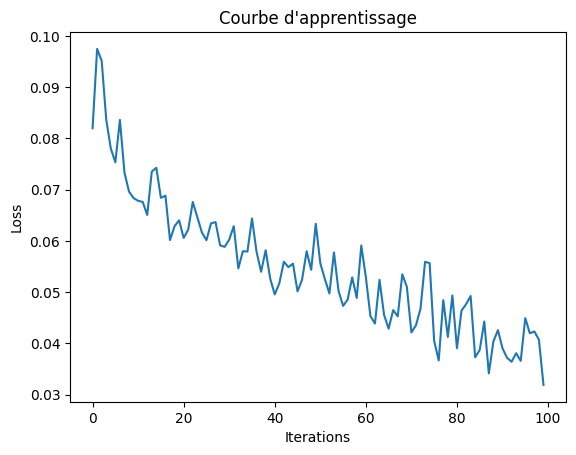

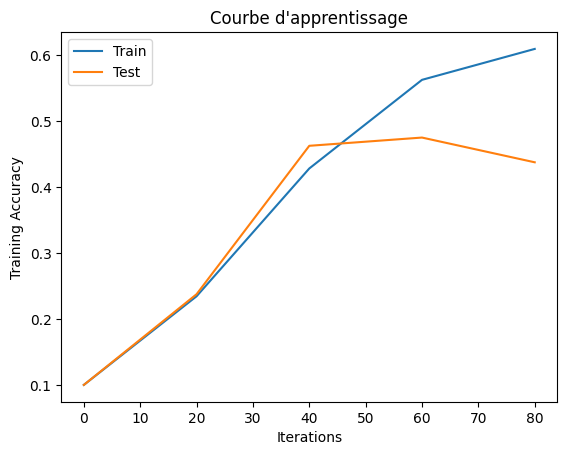

Précision finale Train : 0.609375
Précision finale Test : 0.4375


In [ ]:
train(model3, batch_size=32, optimizer="adam", learning_rate=0.0001, num_epochs=10)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


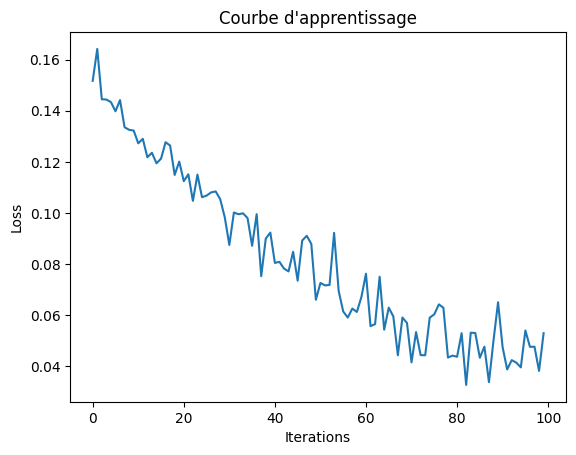

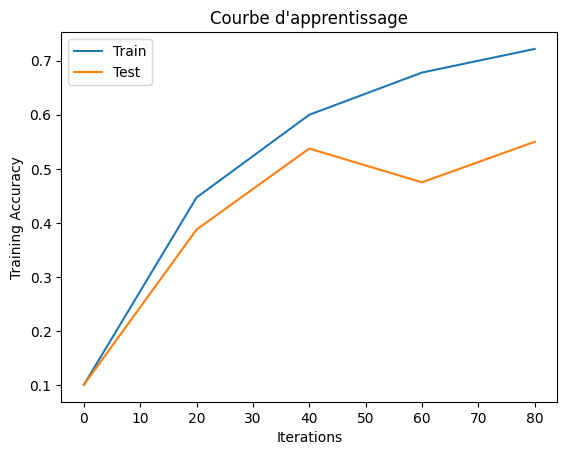

Précision finale Train : 0.721875
Précision finale Test : 0.55


In [ ]:
modelCNN4 = CNN()
print(model4)

# batch size de 32 a 16
train(modelCNN4, batch_size=16, optimizer="adam", learning_rate=0.0001, num_epochs=10)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


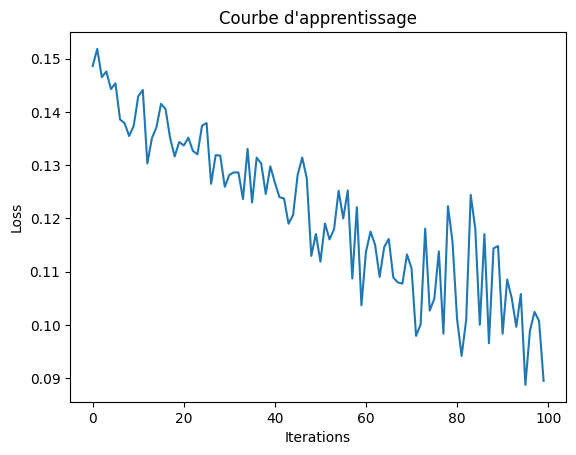

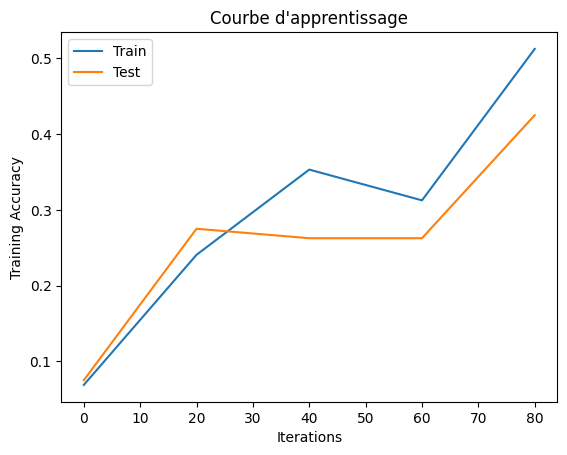

Précision finale Train : 0.5125
Précision finale Test : 0.425


In [ ]:
model5 = CNN()
print(model5)

# optimizer : sgd
train(model5, batch_size=16, optimizer="sgd", learning_rate=0.0001, num_epochs=10)

In [ ]:
# normaliser les activations de chaque couche
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1,8,3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,3)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*14*25, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1,32*14*25) # flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

CNN2(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


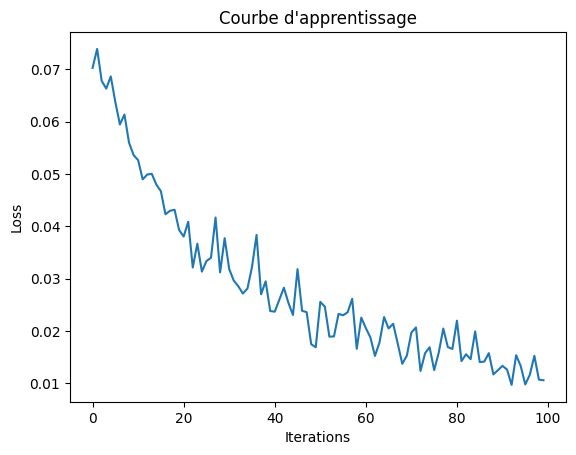

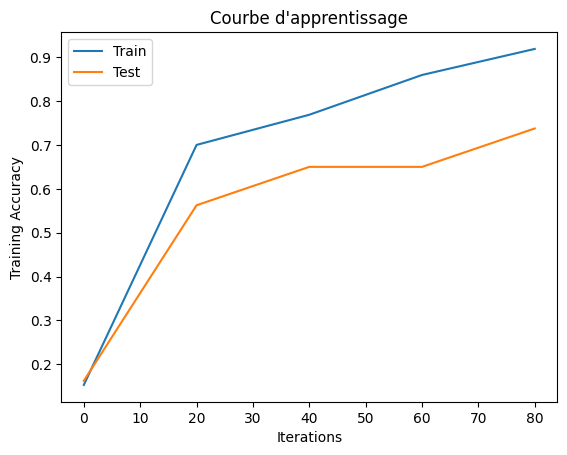

Précision finale Train : 0.91875
Précision finale Test : 0.7375


In [ ]:
modelCNN2 = CNN2()
print(modelCNN2)

train(modelCNN2, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

CNN2(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


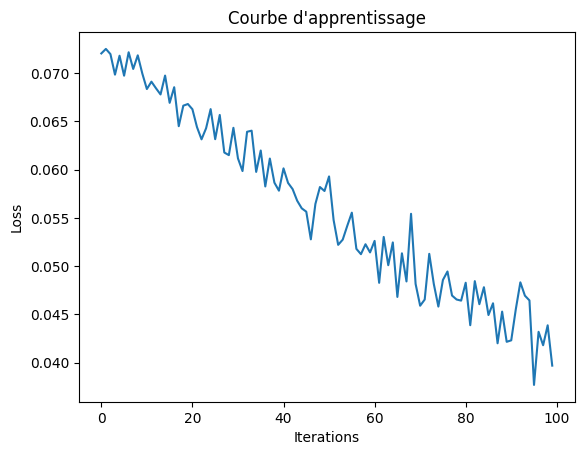

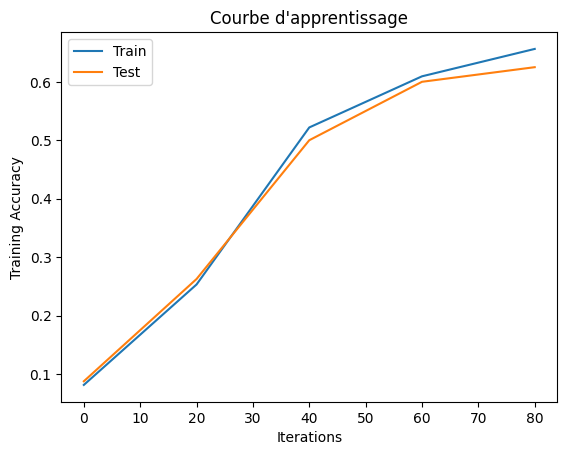

Précision finale Train : 0.65625
Précision finale Test : 0.625


In [ ]:
modelCNN2_sgd = CNN2()
print(modelCNN2_sgd)

train(modelCNN2_sgd, batch_size=32, weight_decay=0.0,optimizer="sgd", learning_rate=0.0001, momentum=0.9, num_epochs=10)

In [37]:
# modifier le nombre de couches cachees
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1,8,3)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16,32,3)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*14*25, 80)
        self.fc2 = nn.Linear(80, 10)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1,32*14*25) # flatten
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)

        return x

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


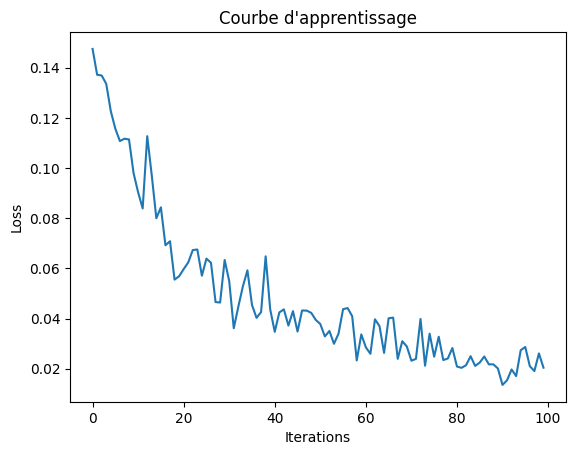

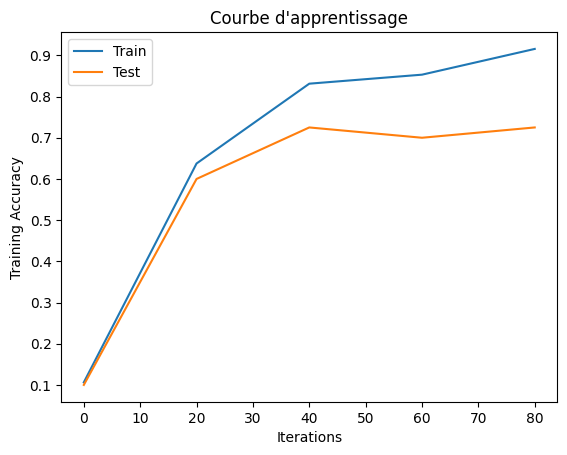

Précision finale Train : 0.915625
Précision finale Test : 0.725


In [41]:
modelCNN3_adam_lr_16 = CNN3()
print(modelCNN3_adam_lr_16)

train(modelCNN3_adam_lr_16, batch_size=16, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


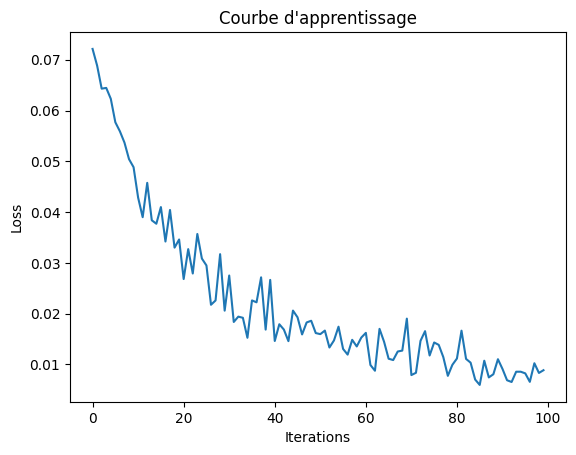

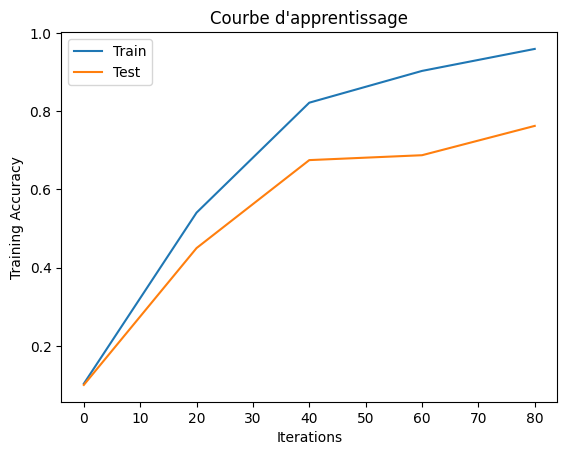

Précision finale Train : 0.959375
Précision finale Test : 0.7625


In [38]:
modelCNN3_adam_lr = CNN3()
print(modelCNN3_adam_lr)

train(modelCNN3_adam_lr, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.0001, momentum=0.9, num_epochs=10)

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


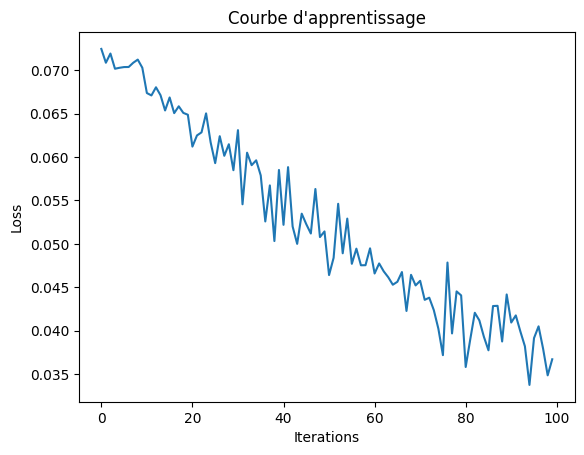

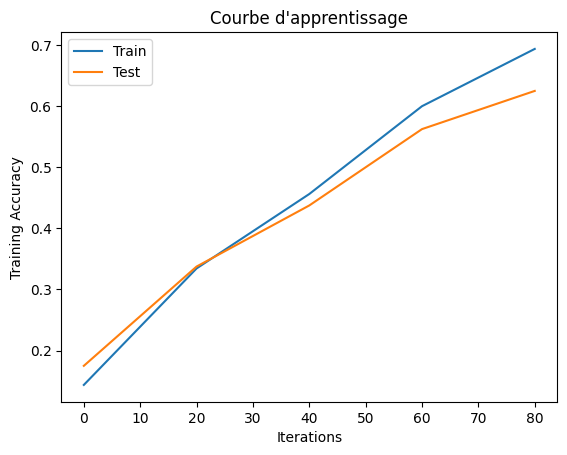

Précision finale Train : 0.69375
Précision finale Test : 0.625


In [39]:
modelCNN3_sgd_lr = CNN3()
print(modelCNN3_sgd_lr)

train(modelCNN3_sgd_lr, batch_size=32, weight_decay=0.0,optimizer="sgd", learning_rate=0.0001, momentum=0.9, num_epochs=10)

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


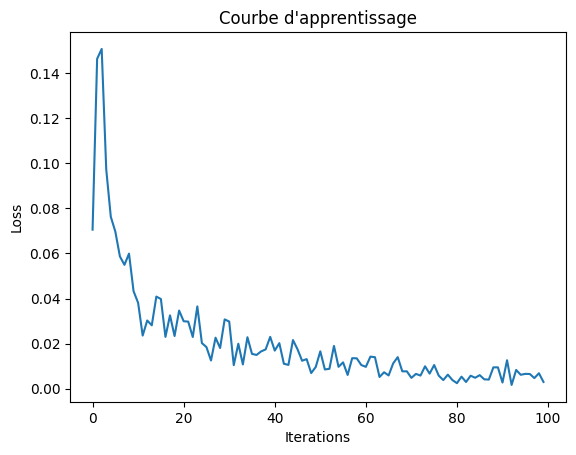

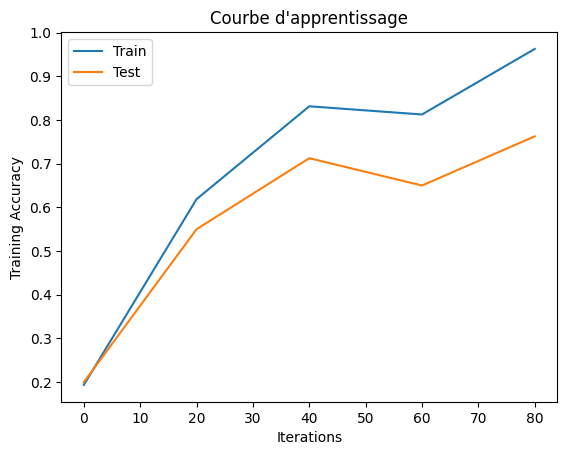

Précision finale Train : 0.9625
Précision finale Test : 0.7625


In [ ]:
modelCNN3_adam = CNN3()
print(modelCNN3_adam)

train(modelCNN3_adam, batch_size=32, weight_decay=0.0,optimizer="adam", learning_rate=0.001, momentum=0.9, num_epochs=10)

CNN3(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=11200, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)


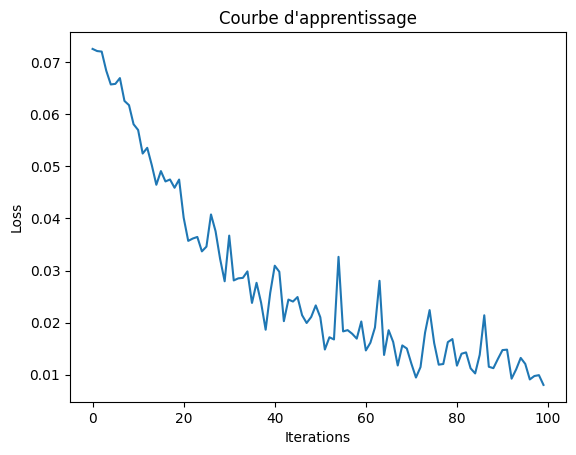

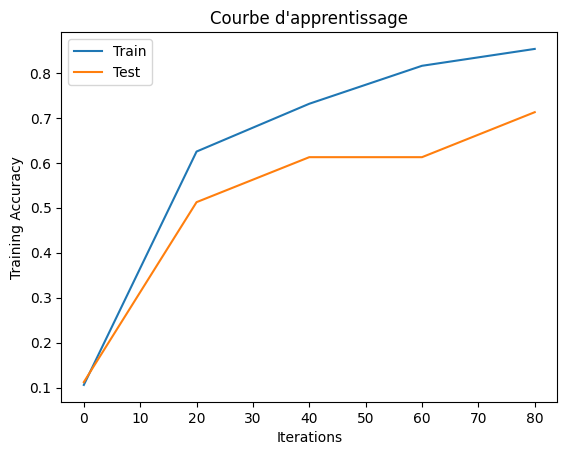

Précision finale Train : 0.853125
Précision finale Test : 0.7125


In [ ]:
modelCNN3_sgd = CNN3()
print(modelCNN3_sgd)

train(modelCNN3_sgd, batch_size=32, weight_decay=0.0,optimizer="sgd", learning_rate=0.001, momentum=0.9, num_epochs=10)

Essayer d'améliorer le MLP, jouer avec son architecture : changer la fonction d'activation, modifier le nombre de couches, ajouter une normalisation des activations...

Même chose avec le CNN.

Vous pouvez améliorer les hyperparamètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre pour la tâche donnée ? Pensez-vous avoir une bonne valeur de taux d'apprentissage pour SGD (et pour ADAM) ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

Pour aller plus loin : quelles augmentations pourraient êter pertinentes pour augmenter les spectrogrammes ?

In [33]:
def matrice_conf(model, test_loader):
  mat_conf = torch.zeros(10, 10)
  model.eval()
  for images, labels in test_loader:
    outputs = model(images)
    _, predictions = torch.max(outputs, 1)
    for true_label, predicted_label in zip(labels.view(-1), predictions.view(-1)):
        mat_conf[true_label.long(), predicted_label.long()] += 1
  return mat_conf

In [34]:
matMLP = matrice_conf(model4, test_loader)
print(matMLP)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


tensor([[6., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 2., 3., 0., 0., 2., 0., 0., 0., 1.],
        [0., 0., 7., 0., 0., 0., 1., 0., 0., 0.],
        [2., 0., 1., 2., 0., 0., 1., 0., 0., 2.],
        [0., 2., 0., 0., 3., 2., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 2., 6., 0., 0., 0.],
        [3., 0., 0., 0., 0., 0., 5., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 7., 0., 1.],
        [0., 0., 0., 0., 0., 0., 5., 0., 3., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 7.]])


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


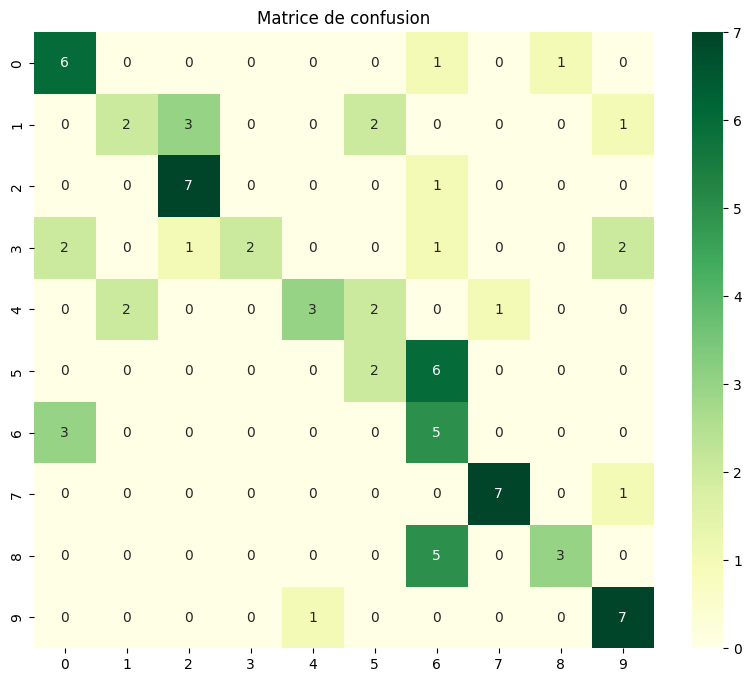

In [36]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(matMLP.numpy(), annot=True, fmt="g", cmap="YlGn", ax=ax)
ax.set_title('Matrice de confusion')

plt.show()

In [42]:
mat = matrice_conf(modelCNN3_adam_lr, test_loader)
print(mat)

tensor([[8., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 7., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 2., 6., 0., 0., 0., 0., 0., 0., 0.],
        [1., 2., 0., 5., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 1., 3., 0., 0., 1., 0., 2.],
        [4., 0., 0., 0., 0., 2., 2., 0., 0., 0.],
        [4., 0., 0., 0., 0., 0., 4., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 7., 0., 0.],
        [2., 0., 0., 0., 0., 0., 0., 0., 6., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 7.]])


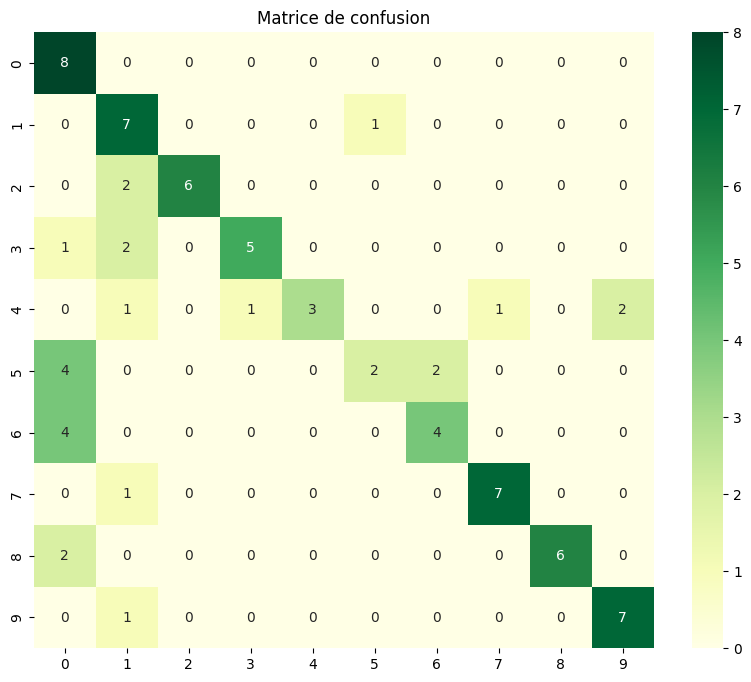

In [44]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(mat.numpy(), annot=True, fmt="g", cmap="YlGn", ax=ax)
ax.set_title('Matrice de confusion')

plt.show()